# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

import sys
import pickle
import torch
import pandas as pd
import matplotlib.pyplot as plt


from PPO import GaussianActorCriticNetwork
from PPO import PPOAgent

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.10199999772012233


In [5]:
def train():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#     if sys.platform == "darwin":
#         binary_path = "./bin/Reacher.app"
#     elif sys.platform == "linux":
#         binary_path = "./bin/Reacher_Linux_NoVis/Reacher.x86_64"
#     else:
#         binary_path = "./bin/Reacher_Windows_x86_64/Reacher.exe"

#     env = UnityEnvironment(file_name=binary_path)
    n_agent, state_dim, action_dim = get_env_info(env)
    model = GaussianActorCriticNetwork(state_dim, action_dim, hiddens=[512, 256])
    model = model.to(device)
    agent = PPOAgent(env, model, tmax=128, n_epoch=10,
                     batch_size=128, eps=0.1, device=device)

    n_step = 2000
    n_episodes = 0
    for step in range(n_step):
        agent.step()
        scores = agent.scores_by_episode
        if n_episodes < len(scores):
            n_episodes = len(scores)
            print(f" episode #{n_episodes} : score = {scores[-1]:.2f}", end="")
            if 100 <= n_episodes:
                rewards_ma = np.mean(scores[-100:])
                print(f", mean score of last 100 episodes = {rewards_ma:.2f}")
                if 30. <= rewards_ma:
                    torch.save(model.state_dict(), "model.pth")
                    with open('rewards.pickle', 'wb') as fp:
                        pickle.dump(scores, fp)
                    print("\n ==== Achieved criteria! Model is saved.")
                    break
            else:
                print()
        sys.stdout.flush()


In [7]:
def get_env_info(env):
    # reset the environment
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    n_agent = len(env_info.agents)
    action_dim = brain.vector_action_space_size
    states = env_info.vector_observations
    state_dim = states.shape[1]

    return n_agent, state_dim, action_dim

In [8]:
train()

 episode #1 : score = 0.48
 episode #2 : score = 0.75
 episode #3 : score = 0.93
 episode #4 : score = 0.88
 episode #5 : score = 1.11
 episode #6 : score = 1.47
 episode #7 : score = 1.48
 episode #8 : score = 2.03
 episode #9 : score = 2.55
 episode #10 : score = 2.73
 episode #11 : score = 3.19
 episode #12 : score = 3.54
 episode #13 : score = 4.96
 episode #14 : score = 3.90
 episode #15 : score = 5.45
 episode #16 : score = 5.23
 episode #17 : score = 5.93
 episode #18 : score = 5.90
 episode #19 : score = 5.97
 episode #20 : score = 6.50
 episode #21 : score = 6.34
 episode #22 : score = 6.74
 episode #23 : score = 7.58
 episode #24 : score = 8.55
 episode #25 : score = 8.82
 episode #26 : score = 9.78
 episode #27 : score = 10.68
 episode #28 : score = 10.20
 episode #29 : score = 11.52
 episode #30 : score = 10.74
 episode #31 : score = 11.08
 episode #32 : score = 11.97
 episode #33 : score = 12.20
 episode #34 : score = 13.15
 episode #35 : score = 15.61
 episode #36 : score

In [9]:

def view():

    n_agent, state_dim, action_dim = get_env_info(env)
    model = GaussianActorCriticNetwork(state_dim, action_dim, hiddens=[512, 256])
    model = model.to(device)

    # load best Model
    state_dict = torch.load("model.pth",
                            map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)

    # Reset Env
    brain_name = env.brain_names[0]
    env_info = env.reset(train_mode=False)[brain_name]
    states = to_tensor(env_info.vector_observations)

    n_step = 5000
    model.eval()
    for step in range(n_step):
        # draw action from model
        actions, _, _, _ = model(states)

        # one step forward
        actions_np = actions.cpu().numpy()
        env_info = env.step(actions_np)[brain_name]
        states = to_tensor(env_info.vector_observations)

When finished, you can close the environment.

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def to_tensor(x, dtype=np.float32):
    return torch.from_numpy(np.array(x).astype(dtype)).to(device)


In [13]:
view()

KeyboardInterrupt: 

In [38]:
def plot(fpath):
    with open(fpath, "rb") as fp:
        scores = pickle.load(fp)

    episodes = np.arange(len(scores)) + 1
    scores = pd.Series(scores)
    avg_scores = scores.rolling(100).mean()
    
    fig, ax = plt.subplots(1, 1, figsize=[15, 10])
    ax.plot(avg_scores, "-", c="green", linewidth=6)
    ax.plot(scores, "-", c="black", alpha=0.7)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Score")
    ax.grid(which="major")
    ax.legend(["Score of Each Episode", "Moving Average of last 100 Episode"\
               ,"Criteria"])
    fig.tight_layout()
    fig.savefig("result.png")
    

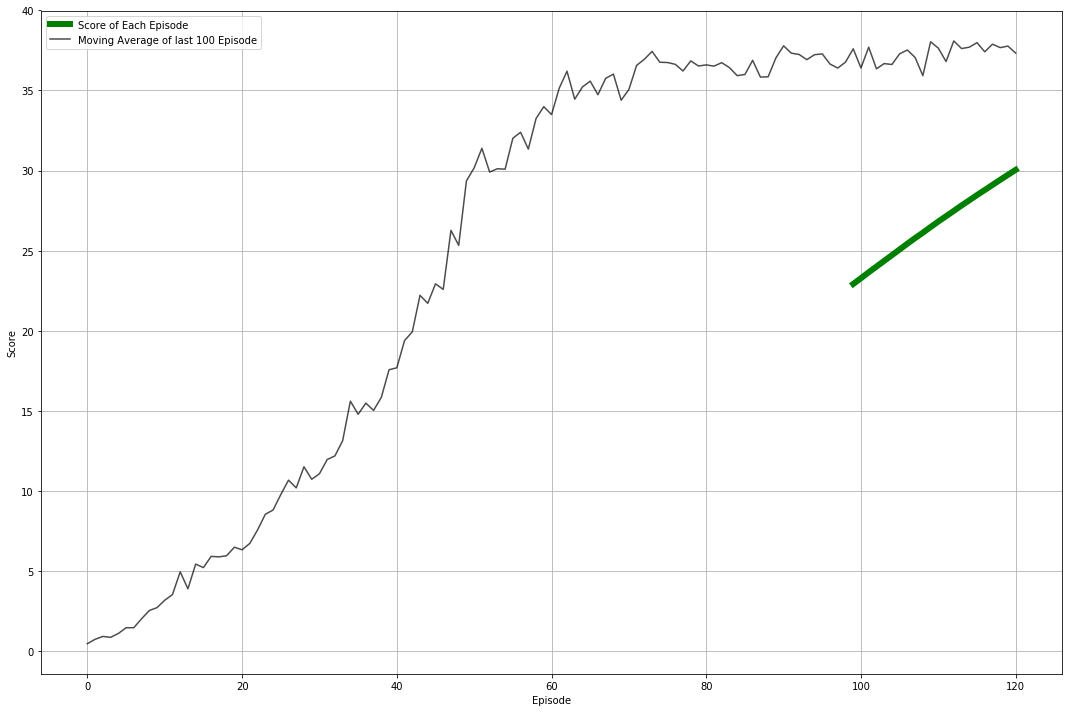

In [39]:
plot("./rewards.pickle")

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 